In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import math
import sklearn

/kaggle/input/sp-500/SP_500.csv


Using TensorFlow backend.


In [13]:
sp5001 = pd.read_csv("../input/sp-500/SP_500.csv")
#sp5001 = pd.read_csv("../input/SP_500.csv")

sp500 = sp5001.iloc[::-1].reset_index(drop=True)

sp500.index = sp500.Date
del sp500['Date']

sp500 = sp500.loc['12/29/2006':]

# Log of Close Price
sp500['plog'] = np.log(sp500.Close)

# Log of Volume
sp500['vlog'] = np.log(sp500.Volume)
sp500.head()

# ret: Return.
sp500['lag_plog']=sp500.plog.shift(1)
sp500['ret']=sp500['plog']-sp500['lag_plog']

# rollstd: Rolling 14-day return standard deviation will be used as a feature to predict volatility. It takes clustering
# effect into consideration and will look back 14 days to compute standard deviation. Arbitrary number, worth 
# thinking over again.
sp500['rollstd']=sp500['ret'].rolling(14).std()

# voldiff: Volume difference, this will be used as input variable to predict volatility.
sp500['lag_vlog']=sp500.vlog.shift(1)
sp500['voldiff'] = sp500['vlog']-sp500['lag_vlog']


# Get rid of Nan values.
sp500 = sp500[14:]
sp500.head()

# absret: Return in absolute form as a measure for volatility.
sp500['absret'] = abs(sp500['ret'])

print(np.mean(sp500['ret']))
# sqret: Mean of return small, assume data around zero and use squared return to denote volatility. Will need to take
# squared root in order to compare predicted results with real results later.
sp500['sqret'] = np.square(sp500['ret'])

# 0.7% as a threshold to determine if volatility is significant and entails more than noise, and thus price movement
# can be explained and forecasted using a price movement model.

# rollstd_07: determine if rollstd > 0.7%.
sp500['rollstd_07'] = sp500.rollstd>0.007
# absret_07: determine is absret > 0.7%.
sp500['absret_07'] = sp500.absret>0.007
sp500.head()

#Split train/test set.
trainset = sp500.loc[:'6/21/2018']
testset = sp500.loc['6/21/2018':]

# Length of train/test set.
ltrain = len(trainset)
ltest = len(testset)

#Proportion of trainset on total dataset.
print(len(testset)/len(sp500))

# Helper Function.
# Variable rescaling function for model fitting.
def reshape(var):
    v_var = var.reshape(-1,1)
    v_var = v_var.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled variable.
    output = scaler.fit_transform(v_var)
    return output, scaler

# Create lookback variables， default lookback period = 1.
# Lookback on itself.
def create_dataset0(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)
# Lookback on an extra variable.
def create_dataset1(Xset, Yset,look_back=1):
    dataX, dataY = [], []
    for i in range(len(Xset) - look_back):
        a = Xset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(Yset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

# All variables that will be used in models.

# Dependent variables. Lags as X variables will created upon Y variables later.
absret = sp500.absret.values
# Scaled.
v_absret, scaler_absret = reshape(absret)

sqret =sp500.sqret.values
# Scaled.
v_sqret, scaler_sqret = reshape(sqret)

# Dummy variable.
absret_07 = sp500.absret_07.values
# Rescaled so that it can fit in create_dataset function.
v_absret07, scaler_absret07 =reshape(absret_07)
# Now datatype is float, ecessary to convert back to boolean?
v_absret07 = v_absret07.astype('bool_')

# Extra X variables.
rollstd = sp500.rollstd.values
# Scaled.
v_rollstd, scaler_rollstd = reshape(rollstd)

#Dummy variable.
rollstd_07 = sp500.rollstd_07.values
v_rollstd07, scaler_rollstd07 = reshape(rollstd_07)
v_rollstd07 = v_rollstd07.astype('bool_')

vlog = sp500.vlog.values
#Scaled.
v_vlog, scaler_vlog = reshape(vlog)

voldiff = sp500.voldiff.values
#Scaled.
v_voldiff, scaler_voldiff = reshape(voldiff)

rolldiff = sp500.absret.values - sp500.rollstd.values
# Scaled.
v_rolldiff, scaler_rolldiff = reshape(rolldiff)

sp500.head()



0.0002543278743186029
0.1200244947948561


,Open,High,Low,Close,Adj Close,Volume,plog,vlog,lag_plog,ret,rollstd,lag_vlog,voldiff,absret,sqret,rollstd_07,absret_07
Date,,,,,,,,,,,,,,,,,
1/23/2007,1422.949951,1431.329956,1421.660034,1427.989990,1427.989990,2975070000,7.264023,21.813533,7.260487,0.003536,0.003599,21.655477,0.158056,0.003536,0.000013,False,False
1/24/2007,1427.959961,1440.140015,1427.959961,1440.130005,1440.130005,2783180000,7.272489,21.746860,7.264023,0.008466,0.004137,21.813533,-0.066673,0.008466,0.000072,False,True
1/25/2007,1440.119995,1440.689941,1422.339966,1423.900024,1423.900024,2994330000,7.261155,21.819986,7.272489,-0.011334,0.005319,21.746860,0.073126,0.011334,0.000128,False,True
1/26/2007,1423.900024,1427.270020,1416.959961,1422.180054,1422.180054,2626620000,7.259946,21.688964,7.261155,-0.001209,0.005020,21.819986,-0.131023,0.001209,0.000001,False,False
1/29/2007,1422.030029,1426.939941,1418.459961,1420.619995,1420.619995,2730480000,7.258849,21.727743,7.259946,-0.001098,0.005017,21.688964,0.038780,0.001098,0.000001,False,False


In [14]:
x1,y1=create_dataset0(v_absret, look_back=14)
x2, y2 = create_dataset1(v_rollstd, v_absret, look_back=14)
x3, y3 = create_dataset1(v_voldiff, v_absret, look_back=14)
x4, y4 = create_dataset1(v_rolldiff, v_absret, look_back=14)
x = np.concatenate((x1, x2, x3, x4), 1)
y = y1

3252
3252
3252
3252


In [15]:
xtrain, xtest = x[:ltrain-14], x[ltrain-14:]
ytrain, ytest = y[:ltrain-14], y[ltrain-14:]

In [16]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

ytrain = np.ravel(ytrain)

score_used = 'r2' 
# set up dictionary for grid search
param_grid = {'alpha':[1.,3.,5.,10.,15.,20.],'gamma':[0.1,0.2,0.5,1.0,2.0],'kernel':['rbf']}

# set up cross-validation shuffles
shuffle_split = ShuffleSplit(test_size=0.1, train_size=0.9, n_splits=25)

# set up search
grid_search = GridSearchCV(KernelRidge(),param_grid,cv=shuffle_split,scoring=score_used, return_train_score=True)
# implement search
grid_search.fit(xtrain,ytrain)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_alpha','param_gamma']])

    rank_test_score  mean_test_score param_alpha param_gamma
0                 1         0.293702           1         0.1
1                 2         0.291882           1         0.2
2                 7         0.266280           1         0.5
3                17         0.186557           1           1
4                25         0.026021           1           2
5                 3         0.286449           3         0.1
6                 4         0.285156           3         0.2
7                10         0.250519           3         0.5
8                20         0.148144           3           1
9                26         0.001007           3           2
10                5         0.279268           5         0.1
11                6         0.277242           5         0.2
12               14         0.233313           5         0.5
13               21         0.120698           5           1
14               27        -0.015732           5           2
15                8     

In [18]:
Model = KernelRidge(alpha =1 , gamma=0.1, kernel = 'rbf')
Model.fit(xtrain, ytrain)

KernelRidge(alpha=1, coef0=1, degree=3, gamma=0.1, kernel='rbf',
            kernel_params=None)

In [21]:
yhat = Model.predict(xtest)
yhat_inverse = scaler_absret.inverse_transform(yhat.reshape(-1, 1))
ytest_inverse = scaler_absret.inverse_transform(ytest.reshape(-1, 1))

In [30]:
threshold = np.zeros(len(yhat_inverse))
threshold = threshold+0.007

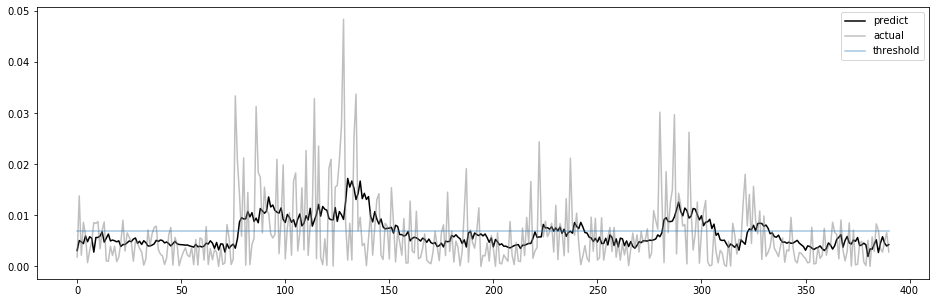

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(figsize=(16,5))
plt.plot(yhat_inverse, label='predict', c='black')
plt.plot(ytest_inverse, label='actual', c='grey', alpha=0.5)
plt.plot(threshold, label='threshold', alpha=0.4)
plt.legend()
plt.show()

In [33]:
# Set threshold to be 0.7% and put prediction/real values in the same table.
testtable = pd.DataFrame(np.hstack((ytest_inverse[:], yhat_inverse[:])))
testtable.columns = ['true', 'hat']
testtable['true07'] = testtable['true']<0.007
testtable['hat07'] = testtable['hat']<0.007
print(testtable.head())

# Generate the confusion matrix.
from sklearn.metrics import confusion_matrix
print(sklearn.metrics.confusion_matrix(testtable.true07.values, testtable.hat07.values))

# Generate accuracy score.
from sklearn.metrics import accuracy_score
print(accuracy_score(testtable.true07.values, testtable.hat07.values))

# Generate roc_auc_score.
from sklearn.metrics import roc_auc_score
print(sklearn.metrics.roc_auc_score(testtable.true07.values, testtable.hat07.values))

       true       hat  true07  hat07
0  0.001860  0.003130    True   True
1  0.013820  0.005082   False  False
2  0.002202  0.004833    True   True
3  0.008642  0.004467   False   True
4  0.006160  0.005963   False  False
[[124  52]
 [110 105]]
0.5856777493606138
0.5964587737843552
